In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports_notebook.py

In [3]:
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
model = GPT2LMHeadModel.from_pretrained("distilgpt2")
model = model.to(device)

In [137]:
import copy

In [4]:
with open('murder.txt') as f:
    text_book = f.read()
    text_book = ' '.join(text_book.split())
    tokens_str_book = tokenizer.tokenize(text_book)
    input_ids_book = tokenizer(text_book, return_tensors='pt').input_ids[0]

Token indices sequence length is longer than the specified maximum sequence length for this model (91920 > 1024). Running this sequence through the model will result in indexing errors


In [5]:
len(input_ids_book)

91920

In [6]:
ak = {'debug': True}
outputs = model(input_ids_book[None, :40].to(device), ak=ak)
Q, K, V = ak['QKV']

ak = {'debug': True}
outputs = model(input_ids_book[None, :41].to(device), ak=ak)
Q1, K1, V1 = ak['QKV']
assert (Q1[..., -2, :]- Q[..., -1, :]).abs().max()<1e-3

In [7]:
Q.shape, Q1.shape

(torch.Size([1, 6, 12, 40, 64]), torch.Size([1, 6, 12, 41, 64]))

In [8]:
(V - V1[:, :, :, :40, :]).abs().max()

tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)

In [9]:
n_context = 40
n_tokens = 1000
Qs, Ks, Vs = [], [], []
for i in tqdm(range(0, 1000)):
    ak = {'debug': True}
    outputs = model(input_ids_book[None, i*n_context: (i+1)*n_context].to(device), ak=ak)
    Q, K, V = ak['QKV']
    Q, K, V = (a.detach() for a in [Q, K, V])
    Qs.append(Q); Ks.append(K); Vs.append(V)
Qs, Ks, Vs = torch.cat(Qs, dim=0), torch.cat(Ks, dim=0), torch.cat(Vs, dim=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [10]:
Qs.shape

torch.Size([1000, 6, 12, 40, 64])

In [110]:
import wandb

In [141]:
torch.manual_seed(0)
n_memories = 80
alpha = 1.
use_adaptive_alpha = True
hm = HopfieldMemory((6, 12, n_memories, 64), alpha=alpha, use_adaptive_alpha=use_adaptive_alpha).to(device)
hm.reset(1.)

print(hm.Km.shape)
beta1 = 1/50.
beta2 = 1000.

n_viz_steps = 5
use_wandb = True

with wandb.init():
    K = Ks[-1]
    A = Q@K.transpose(-1, -2)
    Am = Q@hm.Km.transpose(-1, -2)
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.hist([to_np(A[idx_layer_viz, idx_head_viz].flatten()), to_np(Am[idx_layer_viz, idx_head_viz].flatten())],
              bins=100, label=['A', 'Am']); plt.legend()

    hm.Km.data[...] = hm.Km.data[...]*K.std(dim=-2, keepdim=True)+K.mean(dim=-2, keepdim=True)
    A = Q@K.transpose(-1, -2)
    Am = Q@hm.Km.transpose(-1, -2)
    plt.subplot(122)
    plt.hist([to_np(A[idx_layer_viz, idx_head_viz].flatten()), to_np(Am[idx_layer_viz, idx_head_viz].flatten())],
              bins=100, label=['A', 'Am']); plt.legend()

    plt.close()

    data = defaultdict(lambda : [])
    for i, (Q, K, V) in tqdm(enumerate(zip(Qs, Ks, Vs)), total=len(Qs)):
        wlog = {}
        # Q, K, V = Qs[0], Ks[0], Vs[0]
        A = Q@K.transpose(-1, -2)
        Am = Q@hm.Km.transpose(-1, -2)

        if n_viz_steps is not None and i%(len(Qs)//n_viz_steps)==0:
            print(f'Step {i}')
            # plt.hist([to_np(A[idx_layer_viz, idx_head_viz].flatten()), to_np(Am[idx_layer_viz, idx_head_viz].flatten())],
                      # bins=100, label=['A', 'Am']); plt.legend()
            # wlog['dist'] = plt.gcf()

            viz.viz_Am(Am[idx_layer_viz, idx_head_viz], beta1, beta2)
            # wlog['Am'] = wandb.Image(Am[idx_layer_viz, idx_head_viz])
            wlog['Am'] = plt.gcf()
            viz.viz_Q_Km(Q[idx_layer_viz, idx_head_viz], hm.Km[idx_layer_viz, idx_head_viz])
            wlog['QKm'] = plt.gcf()

        T = K

        hm.set_target_with_data(T, None, beta1=beta1, beta2=beta2)
        hm.step()

#         spread_T = (T[..., :, None, :]-T[..., None, :, :]).norm(dim=-1).mean(dim=(-1,-2))
#         spread_Km = (hm.Km[..., :, None, :]-hm.Km[..., None, :, :]).norm(dim=-1).mean(dim=(-1,-2))

#         n_unique_T = calc_n_unique_vectors(T)
#         n_unique_Km = calc_n_unique_vectors(hm.Km)
#         data['spread_T'].append(spread_T)
#         data['spread_Km'].append(spread_Km)
#         data['n_unique_T'].append(n_unique_T)
#         data['n_unique_Km'].append(n_unique_Km)

        wandb.log(copy.copy(wlog))
        for key, value in wlog.items():
            if isinstance(value, plt.Figure):
                plt.close(value)

# wandb.finish()

torch.Size([6, 12, 80, 64])
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/1000 [00:00<?, ?it/s]

Step 0
Step 200
Step 400
Step 600
Step 800


In [75]:
idx_layer_viz, idx_head_viz = 3, 0

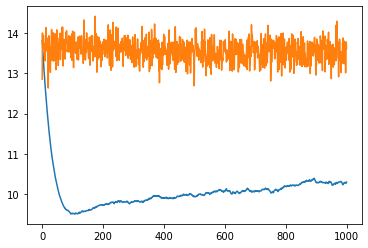

In [76]:
a = torch.stack(data['spread_Km'])
plt.plot(to_np(a[:, idx_layer_viz, idx_head_viz]))
a = torch.stack(data['spread_T'])
plt.plot(to_np(a[:, idx_layer_viz, idx_head_viz]))

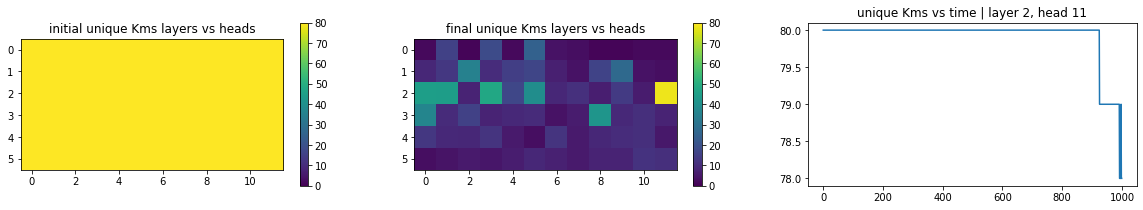

In [79]:
idx_layer_viz, idx_head_viz = 2, 11
a = torch.stack(data['n_unique_Km'])
plt.figure(figsize=(20,3))
plt.subplot(131); plt.title('initial unique Kms layers vs heads')
plt.imshow(to_np(a[0]), vmin=0, vmax=n_memories); plt.colorbar()
plt.subplot(132); plt.title('final unique Kms layers vs heads')
plt.imshow(to_np(a[-1]), vmin=0, vmax=n_memories); plt.colorbar()
plt.subplot(133); plt.title(f'unique Kms vs time | layer {idx_layer_viz}, head {idx_head_viz}')
plt.plot(to_np(a[:, idx_layer_viz, idx_head_viz]))

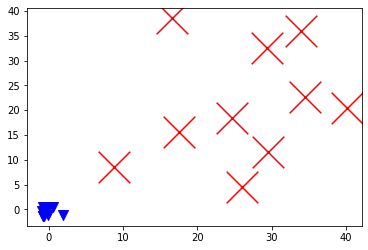

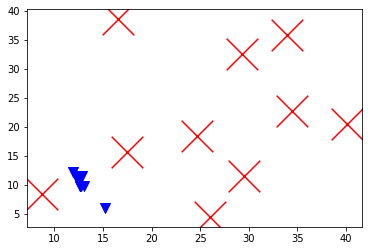

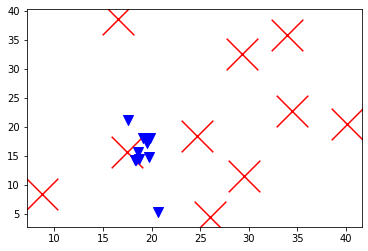

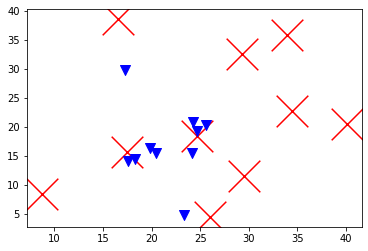

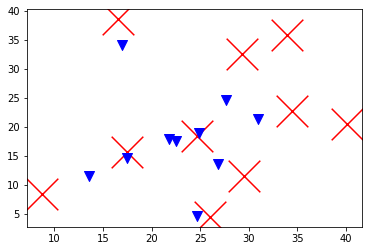

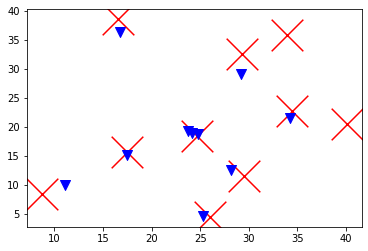

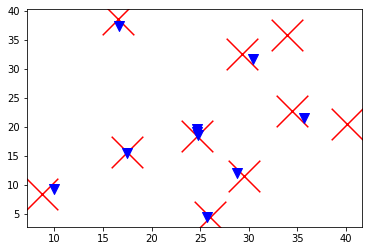

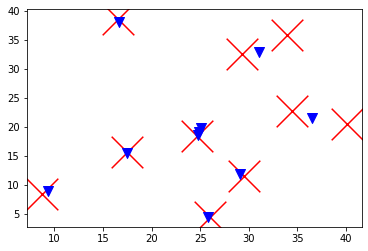

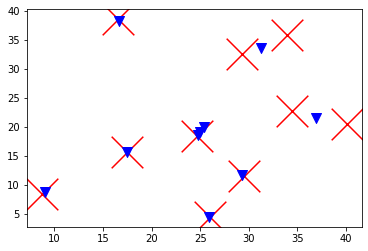

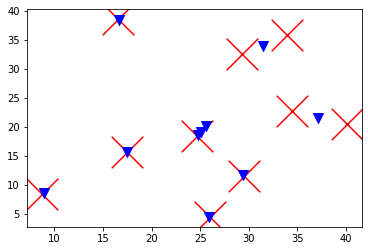

In [194]:
torch.manual_seed(0)

q = torch.randn(10, 2)*10 + 20.
hm = HopfieldMemory((10, 2), alpha=5., use_uniform_steps=1., rigidity=0.)
hm.reset(1.)

for i in range(10):
    plt.scatter(*to_np(q).T, c='r', marker='x', s=1000)
    plt.scatter(*to_np(hm.Km).T, c='b', marker='v', s=100)
    plt.show()
    
    activation, step_size = hm.set_target_with_data(q, dist_metric='euclidean', beta1=1., beta2=10.)
    hm.step()
    
    plt.title('Am'); plt.imshow(Am); plt.colorbar()
    plt.subplot(n_iters, 5, i*5+3)
    plt.title('Am.sm(-1)'); plt.imshow((beta1*Am).softmax(dim=-1)); plt.colorbar()
    plt.subplot(n_iters, 5, i*5+4)
    plt.title('Am.sm(-1).sm(-2)'); plt.imshow((beta2*(beta1*Am).softmax(dim=-1)).softmax(dim=-2)); plt.colorbar()
    plt.subplot(n_iters, 5, i*5+5)
    plt.title('Am.sm(-2)'); plt.imshow((beta1*Am).softmax(dim=-2)); plt.colorbar()
